In [319]:
import math
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch.nn.functional as F
import torch.nn as nn

In [253]:
ds = open('/Users/peternyman/Documents/GitHub/StreamRL/tiny-llm/traning_sets/input.txt', 'r', encoding='utf-8').read()

In [254]:
ds[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [255]:
chars = sorted(list(set(ds)))

# string -> index
stoi = {s: i for i, s in enumerate(chars)}
# index -> string
itos = {i: s for i, s in enumerate(chars)}

# text to list of int
enconder = lambda s: [stoi[c] for c in s]
decoder = lambda l: ''.join([itos[i] for i in l])

print(enconder('I am an AI'))
print(decoder([21, 1, 39, 51, 1, 39, 52, 1, 13, 21]))

print(''.join(chars))

[21, 1, 39, 51, 1, 39, 52, 1, 13, 21]
I am an AI

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [256]:

def get_batch(ds):
    X, Y = [], []
    
    ix = torch.randint(0, len(ds) - context_len -1, (batch_size,))
    
    for i in ix:
        X.append([stoi[c] for c in ds[i : i+context_len]])
        Y.append([stoi[c] for c in ds[i+1 : i+context_len+1]])
    return torch.tensor(X), torch.tensor(Y)


n1 = int(len(ds) * 0.9)

dsTr = ds[:n1]
dsDev = ds[n1:]

X, Y = get_batch(dsTr)

In [400]:
# self-attention


class Head(nn.Modual):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(C, head_size, bias=False)
        self.query = nn.Linear(C, head_size, bias=False)
        self.value = nn.Linear(C, head_size, bias=False)

    def forward(self, x):
        B,T,C = x.shape
        k = self. key(x)   # (B, T, 16)
        q = self.query(x) # (B, T, 16)
        wei = q @ k.transpose(-2,-1) * head_size**0.5 # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
        
        tril = torch.tril(torch.ones(T, T))
        wei = wei.masked_fill(tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        
        v = self.value(x)
        out = wei @ v
        return out


AttributeError: module 'torch.nn' has no attribute 'Modual'

In [398]:
head = Head(n_emb)
# C = torch.randn((len(chars)            ,n_emb))
W1 = torch.randn((n_emb                ,n_hidden)) * (5/3)/((n_emb)**0.5) # gain(tanh)/sqrt(fan_in)
b1 = torch.randn((1                    ,n_hidden)) * 0.02
W2 = torch.randn((n_hidden             ,len(chars))) * 0.01
b2 = torch.randn((1                    ,len(chars))) * 0

parameters = [head,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

AttributeError: 'int' object has no attribute 'shape'

In [258]:
lri = []
lrei = []
lossi = []
steps = 0

In [302]:
def forward(X):
    B, T = X.shape
    
    # forward pass
    emb = C[X]
    embcat = emb.view(B*T, n_emb)
    hpreact = embcat @ W1 + b1
    # SHOULD ADD: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift Papper
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    logits = logits.view(B, T, len(chars))
    return logits ,h,hpreact

In [303]:
max_steps = 200000

lre = torch.linspace(-3, -1, max_steps)
lrs = 10**lre

for i in range(max_steps):
    # construct minibatch
    Xb, Yb = get_batch(dsTr) # batch X,Y

    # forward pass
    logits,h,hpreact = forward(Xb)
    B, T, V = logits.shape # Batch size X context length X Embedding dimension

    loss = F.cross_entropy(logits.view(B*T, V), 
                           Yb.view(B*T)) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # tracking learning rate
    lri.append(lr)
    lrei.append(lre[i])
    lossi.append(loss.item())

steps += max_steps 

      0/ 200000: 2.3420
  10000/ 200000: 2.5189
  20000/ 200000: 2.2842
  30000/ 200000: 2.6249
  40000/ 200000: 2.3592
  50000/ 200000: 2.6469
  60000/ 200000: 2.5392
  70000/ 200000: 2.7870
  80000/ 200000: 1.8532
  90000/ 200000: 2.5530
 100000/ 200000: 2.2122
 110000/ 200000: 2.2904
 120000/ 200000: 2.3512
 130000/ 200000: 2.4573
 140000/ 200000: 2.4836
 150000/ 200000: 2.2563
 160000/ 200000: 2.5375
 170000/ 200000: 2.3064
 180000/ 200000: 2.3441
 190000/ 200000: 2.3174


[1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0]

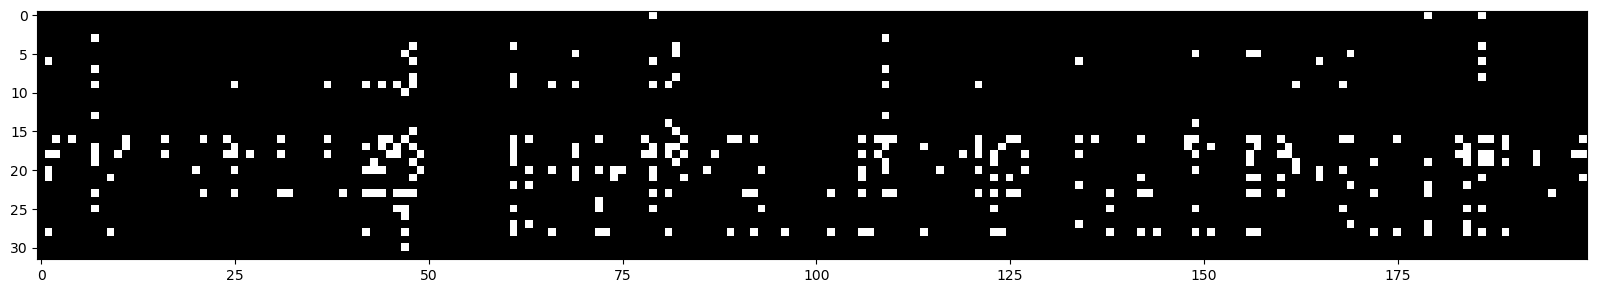

In [307]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

ddORae = [1 if any(e.abs() > 0.99 for e in n) else 0 for n in h]
ddORae

(array([240.,  50.,  46.,  47.,  63.,  51.,  48.,  57.,  54.,  65.,  53.,
         50.,  55.,  49.,  69.,  68.,  62.,  84.,  84., 126., 184., 161.,
        247., 426., 739., 706., 480., 268., 219., 131., 116., 109.,  91.,
         79.,  64.,  49.,  50.,  52.,  55.,  55.,  42.,  42.,  60.,  50.,
         51.,  51.,  46.,  68.,  55., 233.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

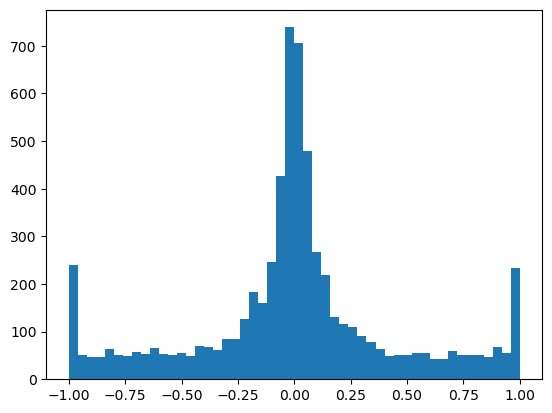

In [306]:
plt.hist(h.view(-1).tolist(), 50)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 4.000e+00, 5.000e+00,
        3.000e+00, 7.000e+00, 1.000e+01, 1.400e+01, 2.100e+01, 1.700e+01,
        3.400e+01, 3.700e+01, 4.300e+01, 5.900e+01, 6.600e+01, 1.650e+02,
        3.010e+02, 5.980e+02, 3.541e+03, 6.620e+02, 2.900e+02, 1.560e+02,
        9.500e+01, 6.400e+01, 5.000e+01, 3.400e+01, 2.900e+01, 1.900e+01,
        1.200e+01, 1.000e+01, 9.000e+00, 7.000e+00, 5.000e+00, 7.000e+00,
        4.000e+00, 6.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([-10.49327087, -10.0976828 ,  -9.70209473,  -9.30650665,
         -8.91091858,  -8.51533051,  -8.11974243,  -7.72415436,
         -7.32856628,  -6.93297821,  -6.53739014,  -6.14180206,
         -5.74621399,  -5.35062592,  -4.95503784,  -4.55944977,
         -4.16386169,  -3.76827362,  -3.37268555,  -2.97709747,
         -2.5815094 ,  -2.18592133,  -1.79033325,  -1.39

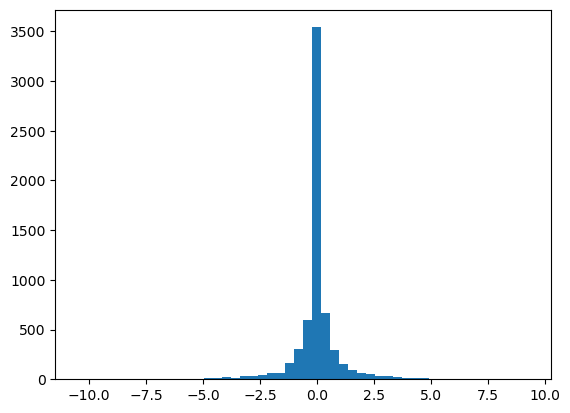

In [305]:
plt.hist(hpreact.view(-1).tolist(), 50)


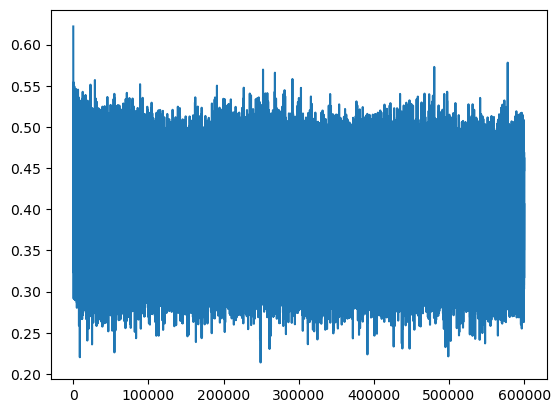

In [304]:
plt.plot([math.log10(l) for l in lossi])

In [294]:
def show_loss(ds):
    Xb, Yb = get_batch(ds)
    
    # forward pass
    logits = forward(Xb)
    B, T, V = logits.shape
    loss = F.cross_entropy(logits.view(B*T, V), 
                           Yb.view(B*T)) 
    return loss.item()
 
print(f'train ds loss: {show_loss(dsTr)}')
print(f'train ds loss: {show_loss(dsDev)}')

train ds loss: 2.2383902072906494
train ds loss: 2.8428285121917725


In [309]:


for _ in range(20):

    out = []
    context = [0]
    while True: 
        
        # forward pass
        logits, _, _ = forward(torch.tensor([context]))
        
        # soft-max beging
        counts = logits.exp() # equivalent to N
        probs = counts / counts.sum(1, keepdim=True)
        # soft-max end
                
        ix = torch.multinomial(probs[-1], num_samples=1).item()

        context = context[1:] + [ix]
        out.append(itos[ix])
        
        if ix == 0:
            break

    print(''.join(out))


UW-rv&QoKukclnkWZKfgURWn$oWL$lY,jsfueZHs,vxFRi

yuUtTxn?iZurpJCvreTyl?KpC?,$LdOfTjiYEihJ,XbM-DEesoWYPMbbrVUgQ;bH

SxHvGGOLC& V&EYHdGbqZuQW!pvNOuyYYS.gvcidr:D-rpamxBUBxGeyb'KNxGomZ,.Qc !Yfu$lHuLPGFqUFJF?VHj$ICmdlquezUNe&qS?aMttNk&oEg'GONFD

H:-c;;V.-iUZfYc;DpGySavfEyB

!xQlEh

dvbUCPJoIsE:HnNYr;awVU:HjhZT$fPJNILsZU?Yln?rlfcM!dap,qT$gKXu'jA gVQTcVlPkY:-LgRVFDjFGH&djljWvXPY$'3GyesjeIuZEvKtxjRp&v-eGi$YUP,Ik&jXR

;nxQ!dsOjvyzxIR&I;x CCE

nekCgPuUsdG-kfopj-iuBb,FLDv sDV;n?VB:TtTlw!oqfSqfGtL$zp'LaZIRoLkLcrwtigjlWvx'IWGyyOoA?ROkKlNy!blEu-CnIQC

aZb Ors$KGfCKBp.qSdbbvEiBdyKVQYalGAirsfNPsrwt&e.lj$,a

GLyBQjwAiRKzZ-fu?G-MoIJTwis,Xru;TEx?boVUf;dYgF$:OzXyevOiGeInpe PriLF H$x

3RY!

ohFdZmIJylQa



KvbIbTsRQE$M-J$lZ vUjhBozE$luvYOlTnVGy3

v'TlOxSEHAcxiX3wmbw:SxtSVGQtRT$S:WOBgEpS 'DeaOs$fiVTKkEuDiIygGmTBo!BUCgDdM&kKnZujp-UF&NZUOWzyv?PcVnecztp-Ebbb?  pUSd-$dAa xJlg

T!T;d$ glL'WSBW3b

nRkTOE!&ChMKpzlWydKDCDwxtJTby3

iyCSER3q,

Cql';dA&H.COozekX3Bc,!RY;B3:Ttj-TNblnx BRUtA?t!w&yBW?PUkQjhztSPq!SF!-we!cKq

['1.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.000120, ', '0.999880, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.839659, ', '0.037255, ', '0.123086, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.105763, ', '0.889829, ', '0.000002, ', '0.004407, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.000001, ', '0.995008, ', '0.002706, ', '0.000004, ', '0.002281, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.004596, ', '0.784258, ', '0.001531, ', '0.030842, ', '0.068719, ', '0.110054, ', '0.000000, ', '0.000000, ']
['0.554605, ', '0.012370, ', '0.020242, ', '0.311510, ', '0.006138, ', '0.094684, ', '0.000451, ', '0.000000, ']
['0.011307, ', '0.000003, ', '0.000001, ', '0.982263, ', '0.000021, ', '0.004595, ', '0.000024, ', '0.001787, ']


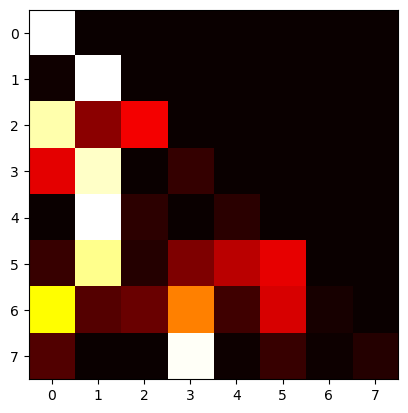

In [394]:
# self-attention

B,T,C = 4,8,32
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2,-1) * head_size**0.5 # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

[print([f'{v:.6f}, ' for v in t]) for t in wei[0]]
plt.imshow(wei[0].detach().numpy()**0.5, cmap='hot', interpolation='nearest')
